# Install MNE package

In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.9 MB/s eta 0:00:00


# Download data

* [paper](https://www.biorxiv.org/content/10.1101/324954v1  ).
* Datasets were collected using EMOTIVE with the 128 Hz sampling frequency.   
* There are two differnt dataset collected in Guinea Bissau (97 subjects) and Nigeria (112 subjects).  
* Here we are dealing with data collected in Guinea Bissau

In [ ]:
!wget https://zenodo.org/record/1252141/files/EEGs_Guinea-Bissau.zip

--2023-09-13 16:43:28--  https://zenodo.org/record/1252141/files/EEGs_Guinea-Bissau.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153973086 (147M) [application/octet-stream]
Saving to: ‘EEGs_Guinea-Bissau.zip’

EEGs_Guinea-Bissau. 100%[===================>] 146.84M   425KB/s    in 6m 17s  

2023-09-13 16:49:47 (399 KB/s) - ‘EEGs_Guinea-Bissau.zip’ saved [153973086/153973086]



# Descomprimir datos

In [ ]:
#unzip the files
from zipfile import ZipFile
data = ZipFile('EEGs_Guinea-Bissau.zip')
data.extractall()

# Leer datos

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
meta_df=pd.read_csv('https://zenodo.org/record/1252141/files/metadata_guineabissau.csv')
meta_df.head()

,subject.id,Group,Eyes.condition,Remarks,recordedPeriod,startTime
0,1,Epilepsy,closed-3min-then-open-2min,by 45s reposition electrodes,301,27/5/2020 14:33
1,2,Control,open-3min-then-closed-2min,NaN,309,26/5/2020 22:44
2,3,Epilepsy,closed-3min-then-open-2min,NaN,309,27/5/2020 14:26
3,4,Epilepsy,closed-3min-then-open-2min,"Green lights not shown, but good EEG traces",299,27/5/2020 15:23
4,5,Control,closed-3min-then-open-2min,NaN,302,23/5/2020 19:09


In [ ]:
#now i need to seprate Epilepsy vs Control subjects
EP_sub=meta_df['subject.id'][meta_df['Group']=='Epilepsy']
CT_sub=meta_df['subject.id'][meta_df['Group']=='Control']

In [ ]:
#read csv files
Epilepsy=[pd.read_csv('EEGs_Guinea-Bissau/signal-{}.csv.gz'.format(i), compression='gzip') for i in  EP_sub]
Control=[pd.read_csv('EEGs_Guinea-Bissau/signal-{}.csv.gz'.format(i), compression='gzip') for i in  CT_sub]

In [ ]:
Epilepsy[0].head()

,Unnamed: 0,AF3,AF4,F3,F4,F7,F8,FC5,FC6,O1,...,CQ_F3,CQ_P7,CQ_P8,CQ_F4,CQ_AF3,CQ_FC5,CQ_O1,CQ_T8,CQ_F8,CQ_DRL
0,1,4426.153846,3994.871795,4408.205128,3847.692308,4690.256410,3895.897436,4702.051282,3914.871795,4049.743590,...,4,4,4,4,4,4,4,4,4,4
1,2,4420.512821,3986.666667,4394.358974,3836.923077,4678.461538,3886.666667,4696.410256,3910.769231,4054.358974,...,4,4,4,4,4,4,4,4,4,4
2,3,4413.846154,3986.153846,4386.666667,3831.794872,4654.871795,3881.025641,4690.769231,3908.205128,4066.666667,...,4,4,4,4,4,4,4,4,4,4
3,4,4407.692308,3984.615385,4384.102564,3832.820513,4644.615385,3883.076923,4686.153846,3910.256410,4063.076923,...,4,4,4,4,4,4,4,4,4,4
4,5,4407.179487,3978.974359,4382.564103,3832.307692,4647.692308,3878.974359,4685.641026,3903.076923,4057.948718,...,4,4,4,4,4,4,4,4,4,4


In [ ]:
#remove non eeg channels
Epilepsy=[i.iloc[:,1:15] for i in  Epilepsy]
Control=[i.iloc[:,1:15] for i in  Control]

# Creación de etiquetas y grupos

In [ ]:
Epilepsy_group=np.concatenate([[i]*len(Epilepsy[i]) for i in range(len(Epilepsy))])#create a list of list where each sub list corresponds to subject_no
Control_group=np.concatenate([[i]*len(Control[i]) for i in range(len(Control))])#create a list of list where each sub list corresponds to subject_no

Epilepsy_label=np.concatenate([[0]*len(Epilepsy[i]) for i in range(len(Epilepsy))])
Control_label=np.concatenate([[1]*len(Control[i]) for i in range(len(Control))])

# Convertir a un objeto MNE

In [ ]:
import mne
def convertDF2MNE(sub):
    info = mne.create_info(list(sub.columns), ch_types=['eeg'] * len(sub.columns), sfreq=128)
    info.set_montage('standard_1020')
    data=mne.io.RawArray(sub.T, info)
    data.set_eeg_reference()
    data.filter(l_freq=0.1,h_freq=45)
    epochs=mne.make_fixed_length_epochs(data,duration=5,overlap=1)
    epochs=epochs.drop_bad()

    return epochs

In [ ]:
%%capture
#Convert each dataframe to mne object
Epilepsy=[convertDF2MNE(i) for i in  Epilepsy]
Control=[convertDF2MNE(i) for i in  Control]

#concatenate the epochs
Epilepsy_epochs=mne.concatenate_epochs(Epilepsy)
Control_epochs=mne.concatenate_epochs(Control)

In [ ]:
#combine data
data=mne.concatenate_epochs([Epilepsy_epochs,Control_epochs])
group=np.concatenate((Epilepsy_group,Control_group))
label=np.concatenate((Epilepsy_label,Control_label))
print(len(data),len(group),len(label))

Not setting metadata
7456 matching events found
No baseline correction applied
7456 3850368 3850368


#Análisis exploratorio de datos (EDA)

In [ ]:
n_epochs = len(data)
n_channels = data.info['nchan']
n_time_points = data.get_data().shape[2]  # Assuming you want the number of time points

# Calculate and display summary statistics for EEG data
eeg_data = data.get_data()  # Get the EEG data
mean_data = np.mean(eeg_data, axis=(0, 2))  # Calculate the mean across epochs and time points
std_data = np.std(eeg_data, axis=(0, 2))    # Calculate the standard deviation

In [ ]:
print("Number of Epochs:", n_epochs)
print("Number of Channels:", n_channels)
print("Number of Time Points:", n_time_points)
print("Mean EEG Data:", mean_data)
print("Standard Deviation of EEG Data:", std_data)

Number of Epochs: 7456
Number of Channels: 14
Number of Time Points: 640
Mean EEG Data: [ 3.51144765 -2.64218414  0.60311247 -2.05465206  0.15494702 -2.24550354
 -0.59592321 -3.18130516  3.56741789 -1.22764511  2.88688713 -1.13943786
  3.27429767 -0.91145874]
Standard Deviation of EEG Data: [255.72212261 207.84962368 223.441376   200.59838069 203.00557177
 223.02197922 185.52768517 199.78149872 219.49533383 202.90647099
 189.86576331 228.73942061 206.70536693 209.12983532]


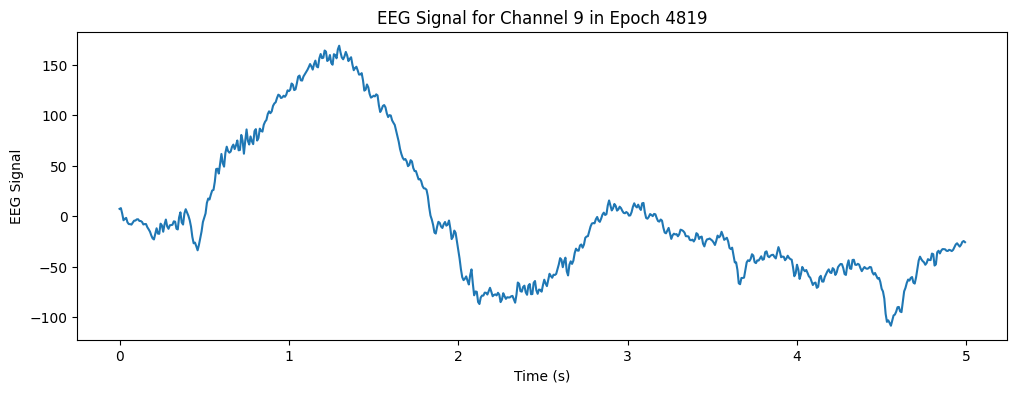

In [ ]:
# Select a random channel and epoch
random_channel = np.random.randint(0, n_channels)
random_epoch = np.random.randint(0, n_epochs)

# Extract the EEG data for the selected channel and epoch
eeg_data = data.get_data()[random_epoch, random_channel, :]

# Create a time vector
time_vector = data.times

# Plot the EEG signal
plt.figure(figsize=(12, 4))
plt.plot(time_vector, eeg_data)
plt.xlabel('Time (s)')
plt.ylabel('EEG Signal')
plt.title(f'EEG Signal for Channel {random_channel} in Epoch {random_epoch}')
plt.show()


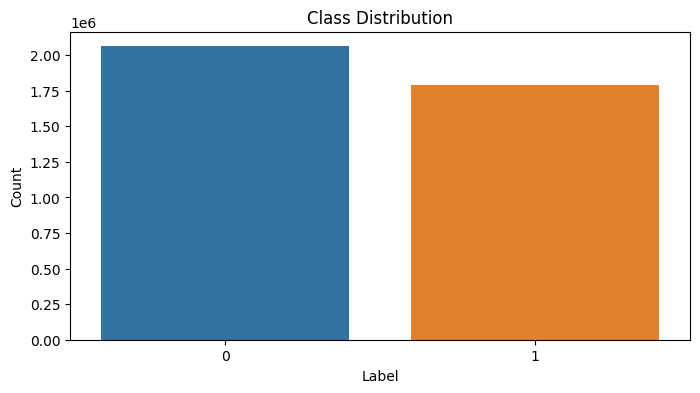

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(x=label)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
# Flatten the EEG data to 2D (epochs x time points * channels)
flattened_data = data.get_data().reshape(data.get_data().shape[0], -1)

# Calculate the correlation matrix between EEG channels
correlation_matrix = np.corrcoef(flattened_data, rowvar=False)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()